In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
import logging
from scipy import fft,signal
import os
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from multiprocessing import Pool
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.structures.neuron_data import NeuronData
#from ephysvibe.structures.eye_data import EyeData
import pandas as pd
import platform
#from ephysvibe.structures.lfp_data import LfpData
from ephysvibe.spike_sorting import config
import h5py
import glob
from joblib import Parallel, delayed
from tqdm import tqdm
from pathlib import Path

In [2]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [3]:
# select sp by sample feature
def get_sp_by_sample(sp,samples,sample_id):
    sp_samples = {}
    for s_id in samples:
        s_sp = sp[np.where(sample_id==s_id,True,False)]
        # Check number of trials
        if s_sp.shape[0] > 0:
            sp_samples[str(s_id)] = s_sp
        else:
            sp_samples[str(s_id)] = np.array([np.nan])
    return sp_samples

In [4]:
def get_avg_fr(sp):
    fr=np.nanmean(sp)*1000
    return fr

In [5]:
def scale_p(x, out_range=(-1, 1)):
    if np.sum(x>1) >0:
        return
    domain = 0, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [6]:
def compute_roc_auc(group1,group2):
    roc_score = []
    p = []
    for n_win in np.arange(group1.shape[1]):
        g1 = group1[:,n_win]
        g2 = group2[:,n_win]
        p.append(stats.ttest_ind(g1, g2)[1])
        thresholds = np.unique(np.concatenate([g1,g2]))
        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0.5
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1>=threshold,g2>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
            score = metrics.auc(fpr[fpr.argsort()],tpr[fpr.argsort()])
        roc_score.append(score)
    roc_score = np.array(roc_score)
    roc_score = scale_p(np.round(roc_score,2),out_range=[-1,1])
    return roc_score,np.array(p)

In [7]:
def find_latency(p_value:np.ndarray,win:int, step:int=1)-> np.ndarray:
    sig=np.full(p_value.shape[0],False)
    sig[p_value<0.05]=True
    for i_step in np.arange(0,sig.shape[0],step):
        sig[i_step] = np.where(np.all(p_value[i_step:i_step+win]<0.05),True,False)
    latency = np.where(sig)[0]
    if len(latency)!=0:
        return latency[0]
    else:
        return np.nan

In [8]:
def get_selectivity(sp_1,sp_2,win):
    if np.logical_or(sp_1.shape[0]<2,sp_2.shape[0]<2):
        return np.nan,np.nan
    roc_score,p_value = compute_roc_auc(sp_1,sp_2)
    lat = find_latency(p_value,win=win,step=1)
    if np.isnan(lat):
        return lat,np.nan
    return lat,roc_score[lat]

In [9]:
def get_align_tr(neu_data,select_block,select_pos,time_before,event ="sample_on"):
    sp,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= select_pos,
        event =event,
        time_before = time_before,
        error_type= 0,
    )
    return sp,mask

In [10]:
def get_neuron_info(path:Path)->Dict:
    neu_info = {}
    # Read neuron data
    neu_data = NeuronData.from_python_hdf5(path)
    time_before=200
    win = 75
    # get spike matrices in and out conditions
    sp_in,mask_in = get_align_tr(neu_data,select_block=1,select_pos=1,time_before=time_before)
    sp_out,mask_out = get_align_tr(neu_data,select_block=1,select_pos=-1,time_before=time_before) 
    # Select durarion to analyze
    sp_in=sp_in[:,:time_before+460+700]
    sp_out=sp_out[:,:time_before+460+700]
    # get avg fr over trials and time
    avgfr_in = get_avg_fr(sp_in)
    avgfr_out = get_avg_fr(sp_out)
    # get fr 
    sp_in=moving_average(data=sp_in,win=100, step=1)
    sp_out=moving_average(data=sp_out,win=100, step=1)
    # split sp by samples id
    
    samples=[11,15,51,55,0]
    for in_out,mask,sp in zip(['in','out'],[mask_in,mask_out],[sp_in,sp_out]):
        sample_id = neu_data.sample_id[mask]
        sp_samples=get_sp_by_sample(sp,samples,sample_id)
        o1 = np.concatenate((sp_samples['11'],sp_samples['15']))
        o5 = np.concatenate((sp_samples['51'],sp_samples['55']))
        c1 = np.concatenate((sp_samples['11'],sp_samples['51']))
        c5 = np.concatenate((sp_samples['15'],sp_samples['55']))
        sample = np.concatenate((sp_samples['11'],sp_samples['15'],sp_samples['51'],sp_samples['55']))
        n0 = sp_samples['0']
        # Check selectivity and latency
        color_lat,color_score = get_selectivity(c1,c5,win=win)
        color_selec = 'c1' if color_score>0 else 'c5' if color_score<0 else 'nan'
        orient_lat,orient_score = get_selectivity(o1,o5,win=win)
        orient_selec = 'o1' if orient_score>0 else 'o5' if orient_score<0 else 'nan'
        neutral_lat,neutral_score = get_selectivity(sample,n0,win=win)
        neutral_selec = 'sample' if neutral_score>0 else 'n0' if neutral_score<0 else 'nan'
        # save results in Dict
        neu_info['color_lat_'+in_out] = color_lat
        neu_info['color_selec_'+in_out] = color_selec
        neu_info['orient_lat_'+in_out] = orient_lat
        neu_info['orient_selec_'+in_out] = orient_selec
        neu_info['neutral_lat_'+in_out] = neutral_lat
        neu_info['neutral_selec_'+in_out] = neutral_selec

    pos_lat,pos_score = get_selectivity(sp_in,sp_out,win=win)
    pos_selec = 'in' if pos_score>0 else 'out' if pos_score<0 else 'nan'
    # extra info
    subject = path.rsplit('/')[-8]
    area = path.rsplit('/')[-3]
    session = path.rsplit('/')[-1].rsplit('_'+subject)[0]
    ch_start = np.load('/envau/work/invibe/USERS/IBOS/openephys/Riesling/'+session+'/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/KS'+area.upper()+'/channel_map.npy')[0][0]
    cluster_ch = neu_data.cluster_ch - ch_start
    matrix_df = pd.read_csv('/home/INT/losada.c/Documents/codes/Users/losadac/data_stats/'+area+'_ch_pos.csv',header=0,index_col=0)
    matrix = matrix_df.values
    matrix = matrix - matrix.min().min()
    row,col = np.where(cluster_ch==matrix)
    # save results in Dict
    neu_info['path'] = path
    neu_info['session']=session
    neu_info['cluster_ch'] = cluster_ch
    neu_info['pos_lat'] = pos_lat
    neu_info['pos_selec'] = pos_selec
    neu_info['avgfr_in'] = avgfr_in
    neu_info['avgfr_out'] = avgfr_out
    neu_info['t_before_s_on'] = time_before
    neu_info['area'] = area
    neu_info['matrix_row'] = row
    neu_info['matrix_col'] = col

    return neu_info

### Start analysis

In [11]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [12]:
areas=['lip','v4','pfc']
paths_info = {'lip':{},'v4':{},'pfc':{}}
for area in areas:
    neu_path = basepath+'session_struct/'+area+'/neurons/*neu.h5'
    path_list = glob.glob(neu_path)
    paths_info[area]['paths']=path_list
    pp = []
    for path in path_list[:300]:
        pp.append(path.rsplit('/')[-1].rsplit('_Riesling')[0])
    paths_info[area]['sessions']=np.unique(pp).tolist()

In [14]:
area_info = {}
for area in ['pfc']:
    all_paths =paths_info[area]['paths'][:500]
    info = Parallel(n_jobs = -1)(delayed(get_neuron_info)(all_paths[i]) for i in tqdm(range(len(all_paths))))
    area_info[area]=info

100%|██████████| 500/500 [20:12<00:00,  2.43s/it]


In [15]:
df_keys=list(area_info[area][0].keys())
df_aux: Dict[str, list] = defaultdict(list)
areas_df = {}
for area in ['pfc']:
    for i in range(len(area_info[area])):
        for key in df_keys:
            df_aux[key] += [area_info[area][i][key]]
    areas_df[area] = pd.DataFrame(df_aux)

In [24]:
channels_info = {'lip':{},'pfc':{},'v4':{}}
for area in ['pfc']:
    df_info = areas_df[area]
    df_sessions = df_info[['session','area']].groupby(['session','area']).count().reset_index()
    n_s = len(df_sessions['session'])
    count_matrix = np.zeros((n_s,8,8))
    count_session=[]
    for i_s in range(n_s):
        # select subset of the df containing session i_s
        session = df_sessions['session'][i_s]
        session_sub=df_info[df_info['session']== df_sessions['session'][i_s]][['matrix_row','matrix_col']].reset_index()
        count_session.append(df_sessions['session'][i_s])
        # select ch positions
        row=session_sub['matrix_row'].to_numpy(dtype=int)
        col = session_sub['matrix_col'].to_numpy(dtype=int)
        # sum number of recorded neurons per channel
        for irow,icol in zip(row,col):
            count_matrix[i_s,irow,icol] +=1
    count_session=np.array(count_session)
    channels_info[area]['session'] = count_session
    channels_info[area]['matrix'] = count_matrix

In [17]:
channels_info[area]['session'] 

TypeError: list indices must be integers or slices, not str

In [ ]:
# area_data = {}
# for area in ['pfc']:
#     matrix_bl = pd.read_csv('/home/INT/losada.c/Documents/codes/Users/losadac/data_stats/'+area+'_ch_pos.csv',header=0,index_col=0)
#     matrix_df = matrix_bl#-matrix_bl.min().min()
#     matrix = matrix_df.values
#     count_matrix = np.zeros(matrix.shape)
#     all_idx_session_paths=[]
#     for i_sess in np.unique(paths_info[area]['sessions']):
#         all_idx_session_paths.append(np.where(np.char.find(paths_info[area]['paths'], i_sess, start=0, end=None)!=-1)[0])
#     data = Parallel(n_jobs = -1)(delayed(count_neu_position)(count_matrix,matrix,paths_info,area,all_idx_session_paths[i]) for i in tqdm(range(len(all_idx_session_paths))))
#     area_data[area]=data


100%|██████████| 7/7 [00:00<00:00, 7399.23it/s]


Text(0.5, 0.98, 'pfc')

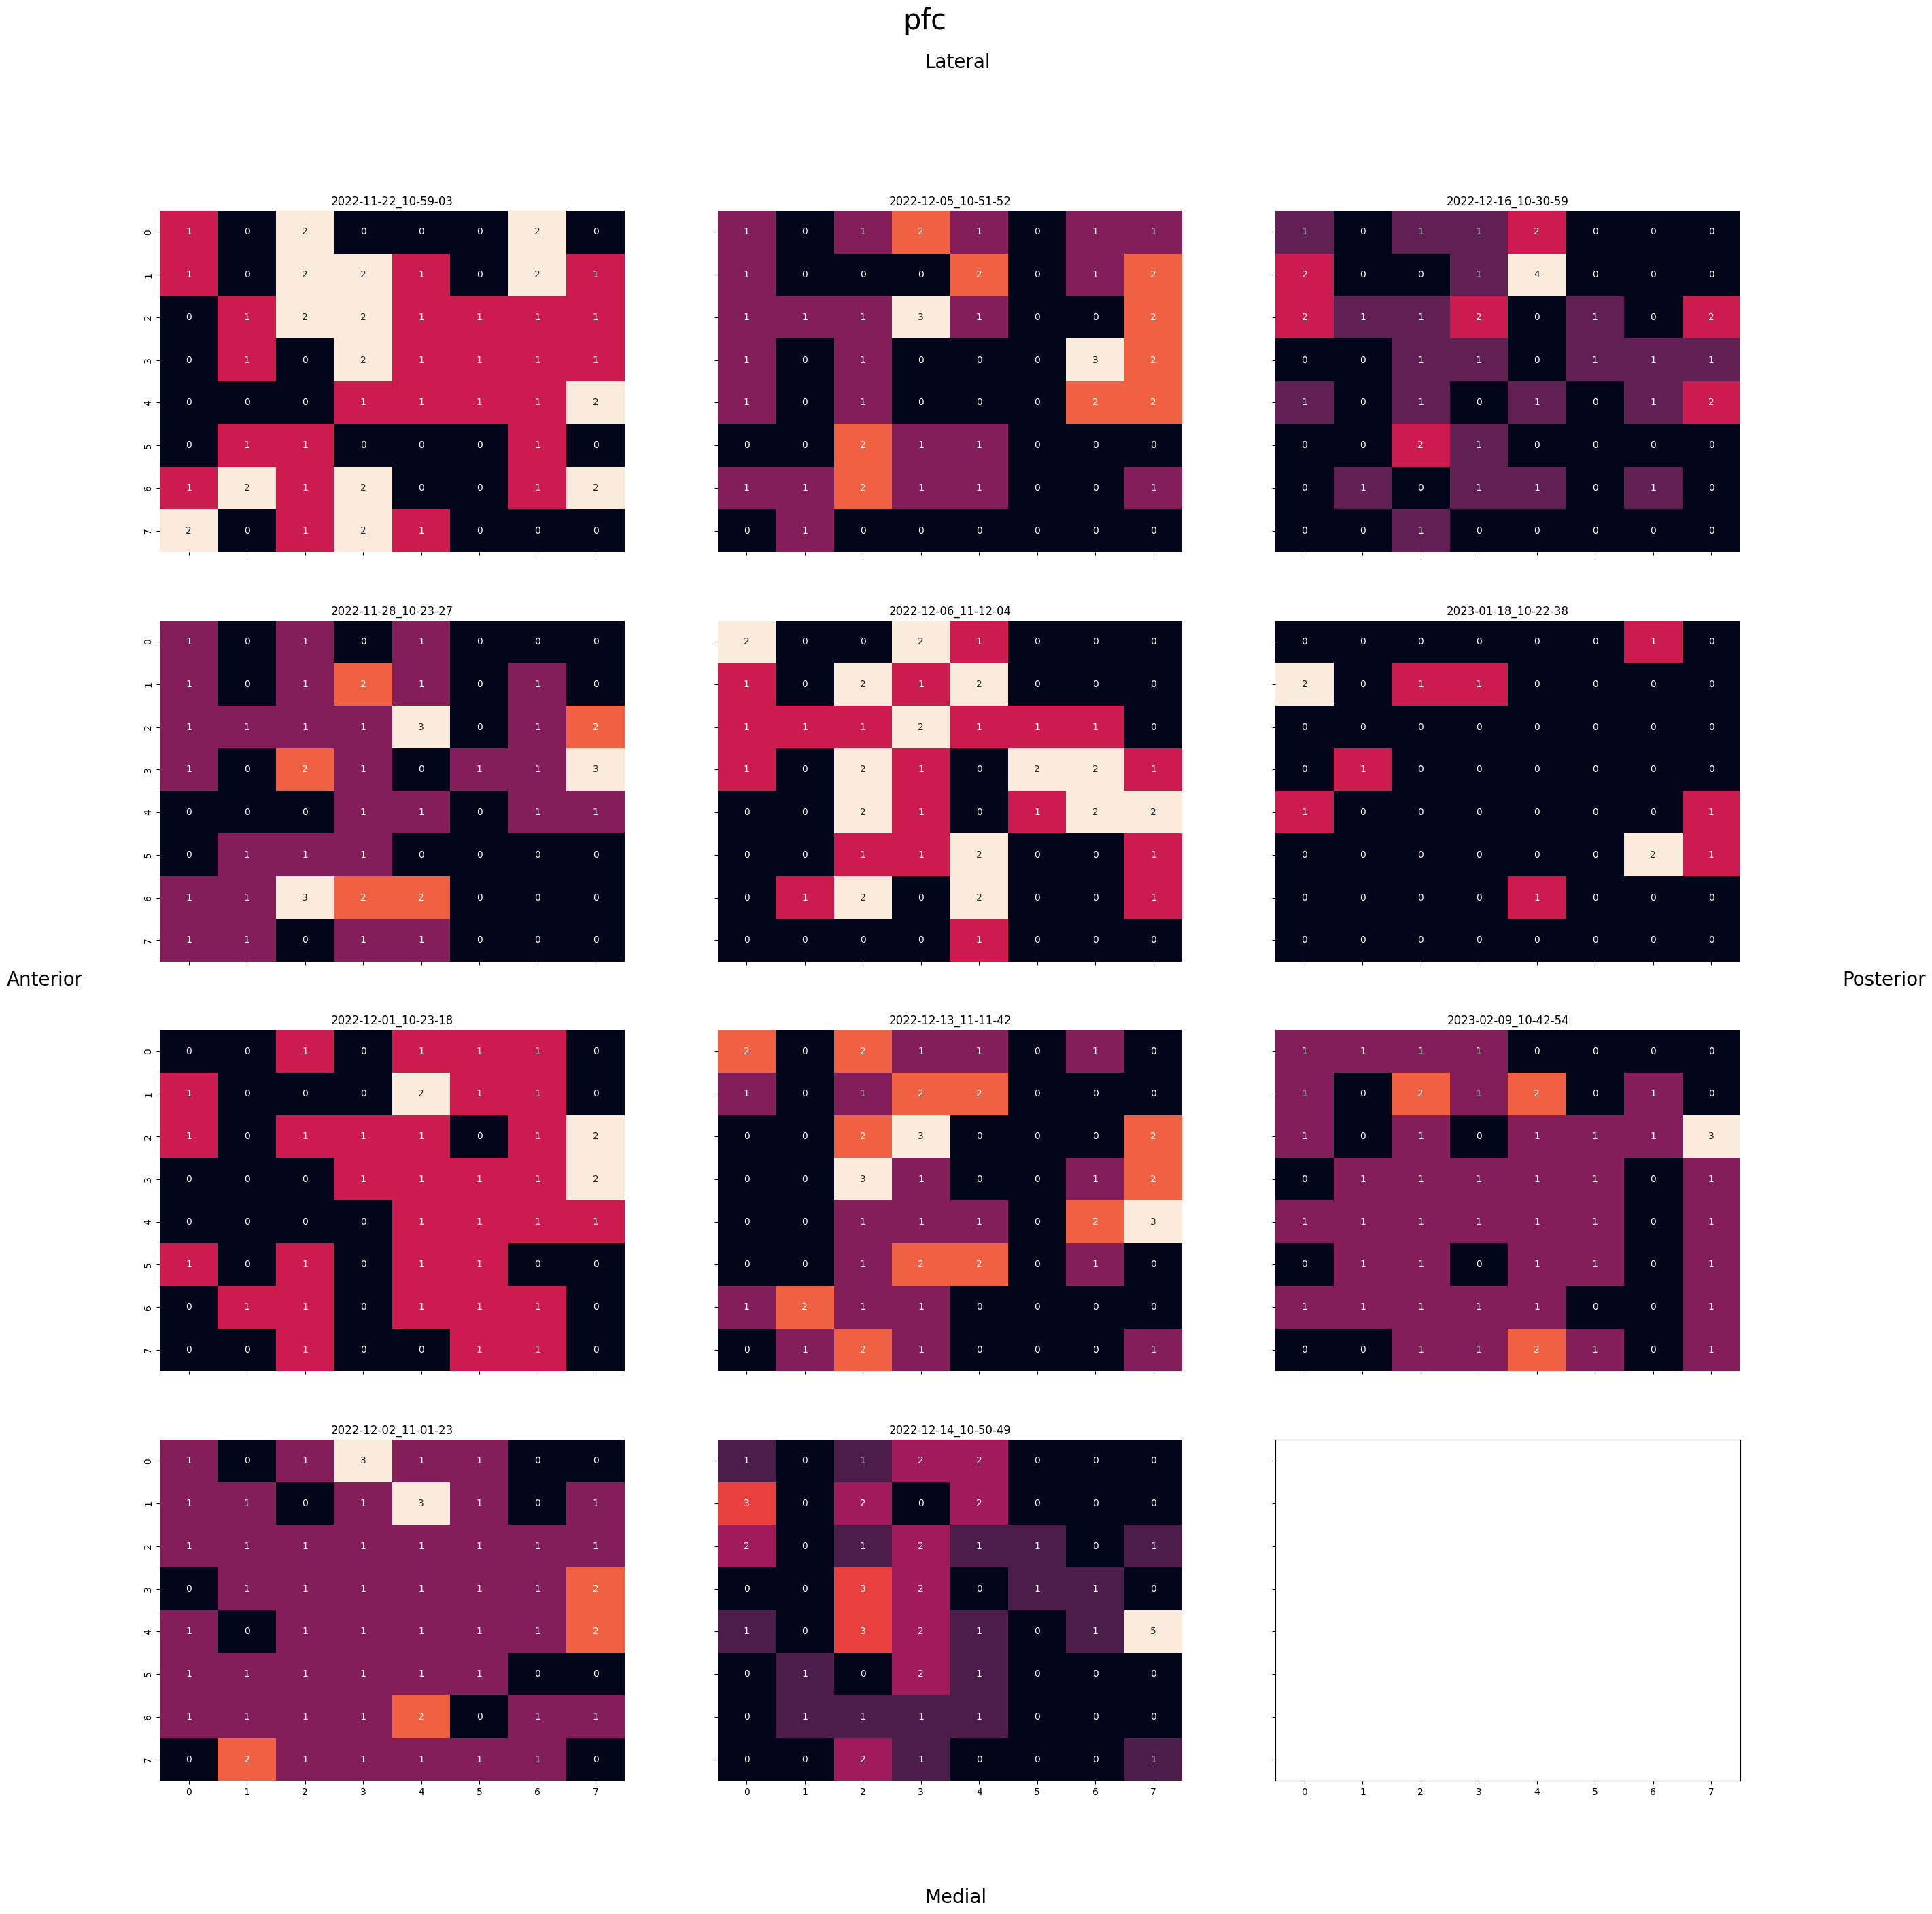

In [35]:
area = 'pfc'
all_cmatrix=channels_info[area]['matrix']
all_sess=channels_info[area]['session']
ncols = 3
nrows = int(np.ceil(all_cmatrix.shape[0]/ncols))
f,ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(30,30),sharex=True,sharey=True)
i_s = 0
for ic in range(ncols):
    for ir in range(nrows):
        sns.heatmap(all_cmatrix[i_s],annot=True,ax=ax[ir,ic],cbar=False)
        ax[ir,ic].set_title(all_sess[i_s])
        i_s+=1
        if i_s==len(all_cmatrix):
            break
f.text(0.5, 0.05, 'Medial'   ,fontsize=20)
f.text(0.5, 0.95, 'Lateral'  ,fontsize=20)
f.text(0.95, 0.5, 'Posterior',fontsize=20)
f.text(0.05, 0.5, 'Anterior' ,fontsize=20)
f.suptitle(area.upper(),fontsize=30)
#f.tight_layout(pad=0.1, h_pad=0.1, w_pad=0.1)